In [1]:
import pandas as pd
import numpy 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
os.chdir('/home/adri/Projects/phd/bias_2')
import re

In [2]:
df = pd.read_csv('data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv')
def is_ala(x):
    
    if type(x) is str:
    
        return bool(re.match('^.\d+$', x))
    else:
        return False
    
df = df[df.Mutant.apply(is_ala)]
df = df[['Position', '%wt expression', 'Emax_avg_corr_Gi2_HU210', 'Emax_avg_corr_bArr1_HU210']]
df.columns = ['mutant', 'expression', 'gi', 'barr1']
df = df.dropna()

In [3]:
path = 'data/processed/features_new.csv'
features = pd.read_csv(path, index_col=0)
simulated_mutants = features.mutant_id.unique()

/tmp/ipykernel_267491/3690528942.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv(path, index_col=0)


In [4]:
new_simulated_mutants = list(map(str, simulated_mutants))

In [5]:
df['simulated'] = df.mutant.isin(new_simulated_mutants)
df['simulated'] = df.simulated.apply(lambda x: 'simulated' if x else 'not simulated')

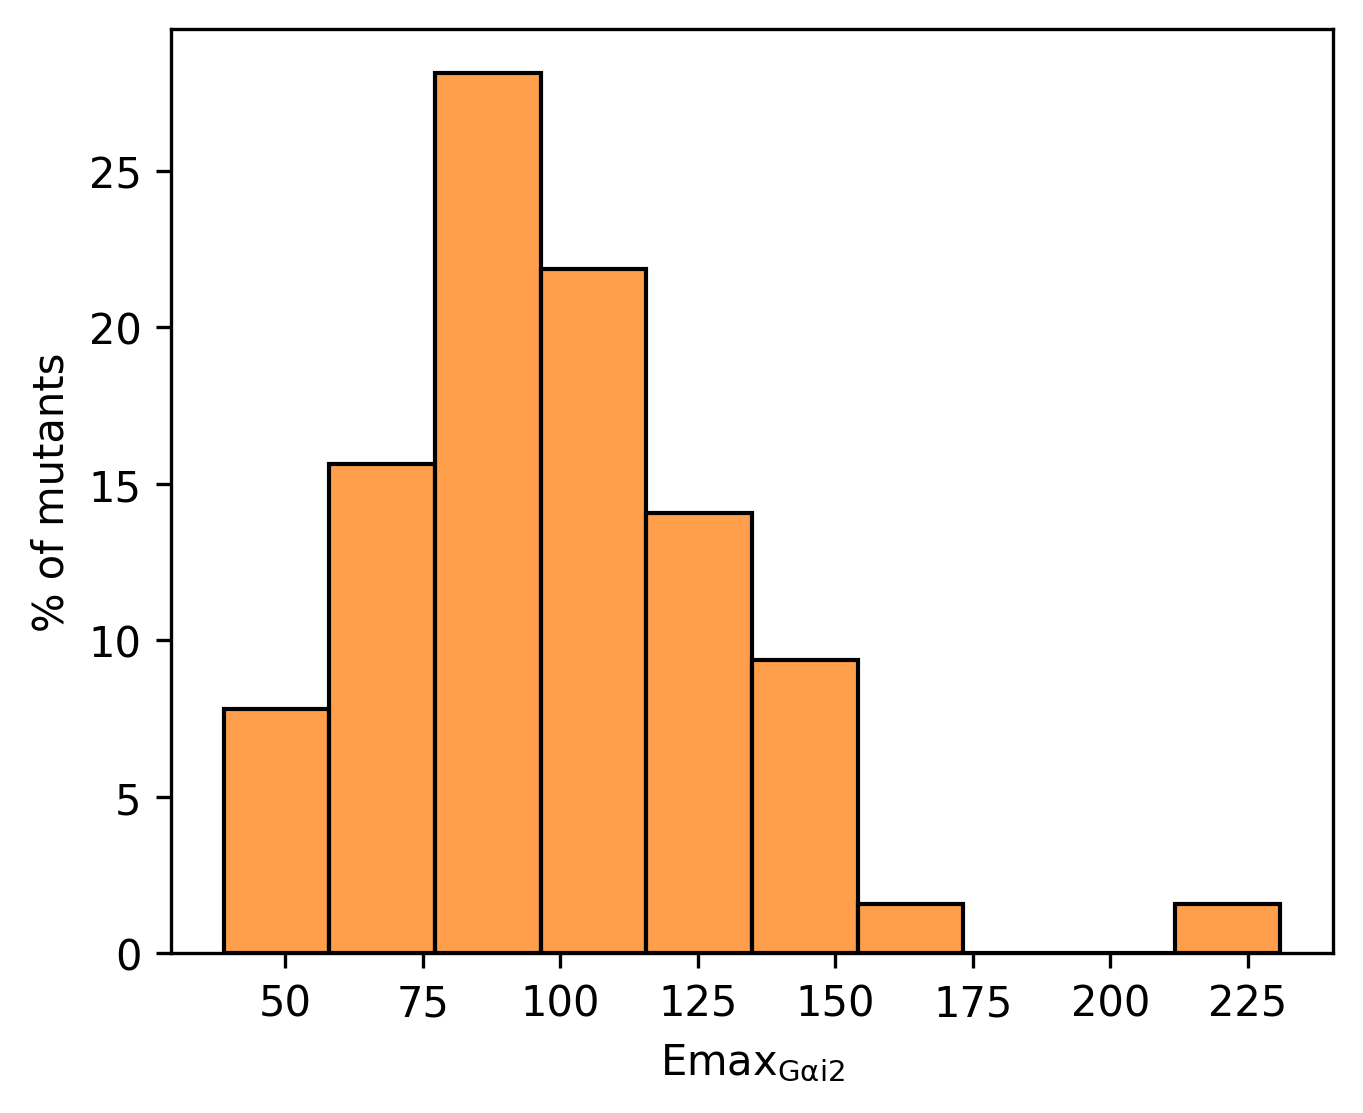

In [6]:
plt.figure(dpi=300, figsize=(5,4))

# create a mask for gi > 0
gi_mask = df.gi > 0
# create a mask for barr = 0
barr_mask = df.barr1 == 0

temp_df = df.copy()
# multiply gi by 100
temp_df.gi = temp_df.gi * 100

sns.histplot(data=temp_df[gi_mask & barr_mask], x='gi', stat='percent', color=sns.color_palette()[1])
plt.xlabel(r'$\mathrm{Emax_{G \alpha i2}}$')
plt.ylabel('% of mutants')
# plt.title('Distribution of Gi emax among Gi-preferred mutants')
plt.show()

In [7]:
df['profile'] = 'WT-like'
m1 = df.barr1 == 0
m2 = df.gi == 0

df['profile'][m1 & m2] = 'both loss'
df['profile'][m1 & ~m2] = 'barr loss'
df['profile'][~m1 & m2] = 'Gi loss'

/tmp/ipykernel_267491/1346182242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profile'][m1 & m2] = 'both loss'
/tmp/ipykernel_267491/1346182242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profile'][m1 & ~m2] = 'barr loss'
/tmp/ipykernel_267491/1346182242.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profile'][~m1 & m2] = 'Gi loss'


In [8]:
profile_df = pd.DataFrame(df.value_counts('profile', normalize=True)).reset_index()

In [9]:
profile_df.columns = ['profile', 'ratio']

In [10]:
palette = np.array(sns.color_palette())[[0,1,3,2]]

In [11]:
new_tick_lables = [r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$', r'$\mathrm{PrefCoup_{G\alpha i2}}$',
                   r'$\mathrm{PrefCoup_{\beta arr1}}$',r'$\mathrm{NoCoup_{G\alpha i2\_\beta arr1}}$',]

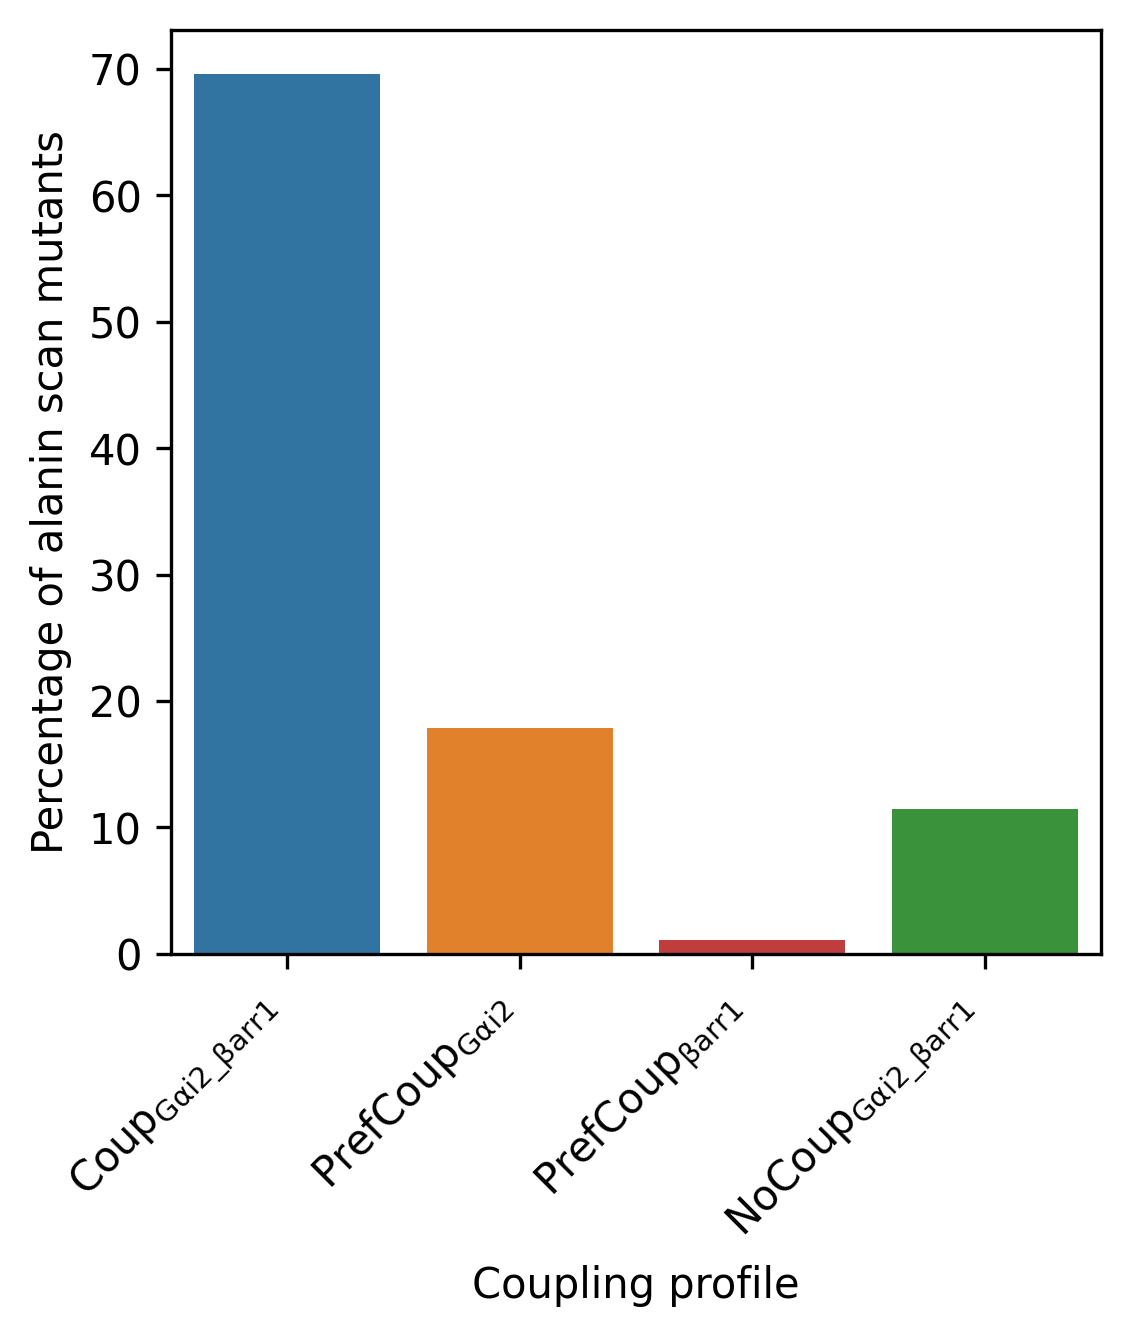

In [12]:
plt.figure(dpi=300, figsize=(4,4))

temp_profile_df = profile_df.copy()
temp_profile_df.ratio = temp_profile_df.ratio * 100

g = sns.barplot(data=temp_profile_df, x='profile', y='ratio', order=['WT-like', 'barr loss', 'Gi loss', 'both loss'], palette=palette)
plt.xlabel('Coupling profile')
plt.ylabel('Percentage of alanin scan mutants')
# plt.title('Proportion of coupling profiles')
plt.xticks(ticks=[0,1,2,3] ,labels=new_tick_lables, rotation=45, ha='right')

plt.show()

In [13]:
conserved_profile = pd.DataFrame([['both loss', 10],
['barr loss', 6],
['Gi loss', 1],
['WT-like', 5]], columns = ['set', 'ratio'])

In [14]:
conserved_profile.ratio = conserved_profile.ratio / conserved_profile.ratio.sum() * 100

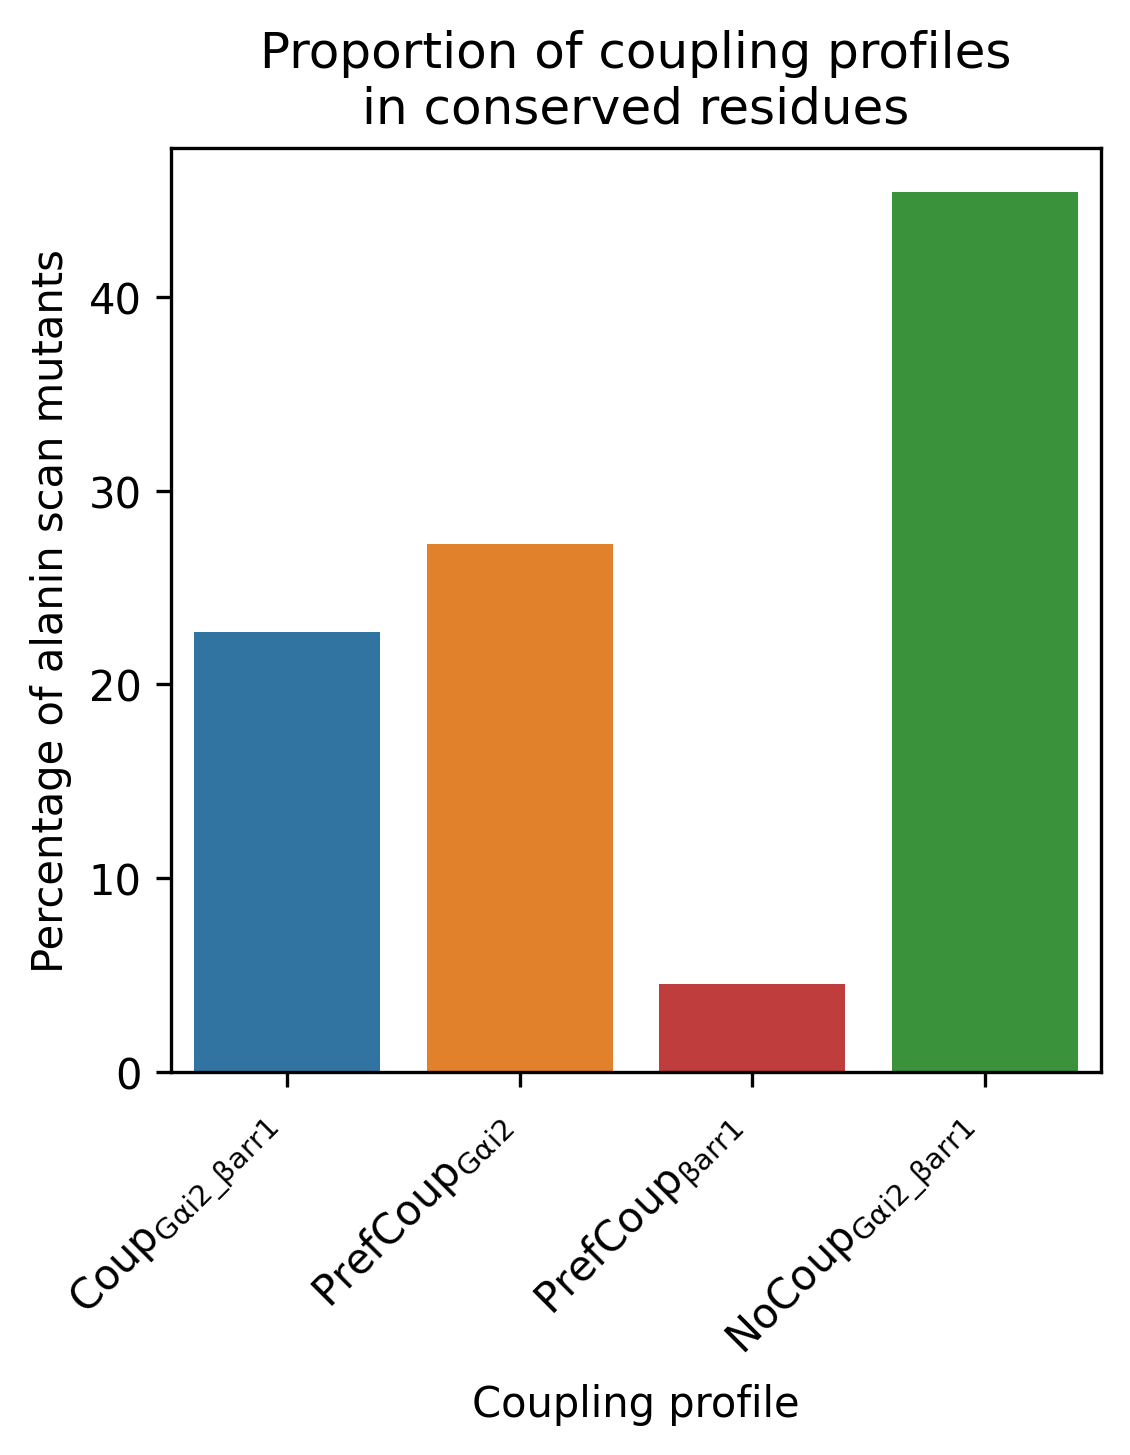

In [15]:
plt.figure(dpi=300, figsize=(4,4))
sns.barplot(data=conserved_profile, x='set', y='ratio', order=['WT-like', 'barr loss', 'Gi loss', 'both loss'], palette=palette)
plt.xlabel('Coupling profile')
plt.ylabel('Percentage of alanin scan mutants')
plt.title('Proportion of coupling profiles\nin conserved residues')
plt.xticks(ticks=[0,1,2,3] ,labels=new_tick_lables, rotation=45, ha='right')
plt.show()

# Conservation by signaling profile 

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import numpy as np
from Bio import pairwise2
from Bio.Seq import Seq
import os

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [17]:
def plot_distributions(df):
    score = 'class_a_score'

    df = df[df.profile_lbl.isin(['wt', 'barr_loss'])]
    
    sns.kdeplot(data=df, x=score, hue='profile_lbl',
                common_norm=False, hue_order=['wt', 'barr_loss'])

    plt.xlabel('Conservation score (JSD)')

    plt.tight_layout()

    # plt.savefig('results/evolutionary_conservation_analysis/bias_enrichment.png', facecolor='white')

In [18]:
path = 'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv'
signaling_df = pd.read_csv(path)

In [19]:
# Read signling data
path = 'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv'
signaling_df = pd.read_csv(path)

# Remove mutations that are not alanin scan
alanin_scan_mask = signaling_df.Mutant.apply(lambda x: bool(re.match('([A-Z])(\d+)$', str(x))))
signaling_df = signaling_df.loc[alanin_scan_mask]

# Remove non usefull columns
cols_of_interst = ['Position','Emax_avg_corr_Gi2_HU210', 'EC50_avg_corr_Gi2_HU210',
                   'Emax_avg_corr_bArr1_HU210', 'EC50_avg_corr_bArr1_HU210', '%wt expression']
signaling_df = signaling_df[cols_of_interst]

# Change column names
signaling_df.columns = ['position', 'gi_emax', 'gi_ec50', 'barr_emax', 'barr_ec50', 'expression']

# Set boolean masks for biased and wt
gi_preferred_mask = (signaling_df.barr_emax == 0) & (signaling_df.gi_emax > 0)
wt_mask = (signaling_df.barr_emax > 0) & (signaling_df.gi_emax > 0)
barr_preferred_mask = (signaling_df.barr_emax > 0) & (signaling_df.gi_emax == 0)
both_mask = (signaling_df.barr_emax == 0) & (signaling_df.gi_emax == 0)

# Create a field wih categorical signal information
signaling_df['profile'] = 3
signaling_df.loc[wt_mask, 'profile'] = 0
signaling_df.loc[gi_preferred_mask, 'profile'] = 1
signaling_df.loc[barr_preferred_mask, 'profile'] = 2


# Remove mutants with other signaling profiles
# signaling_df = signaling_df[signaling_df.profile != 2]

In [20]:
# Add string labels
def cat_profile(x):
    if x == 0:
        return 'wt'
    elif x == 1:
        return 'barr_loss'
    elif x == 2:
        return 'Gi_loss'
    elif x == 3:
        return 'both_loss'
    
signaling_df['profile_lbl'] = signaling_df.profile.apply(cat_profile)

# Convert the residue id into a int column
signaling_df.position = signaling_df.position.astype(int)

In [21]:
def get_conservation_df(basename):   
    
    # Load alignment dataframe
    alignment_df = pd.read_csv(f"data/raw/{basename}_gpcr_alignment.csv", index_col=0, header=1)
    
    # Extract the alignment of the cb2
    cb2_alignment = alignment_df.loc['[Human] CB2 receptor'].values
    
    # Extract the sequence without gaps
    alignment_cb2_seq = ''.join([res for res in cb2_alignment if res not in  ['_', '-']])
    
    # Get the sequence from uniprot
    uniprot_cb2_sequence = 'MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLLSALENVAVLYLILSSH'\
    'QLRRKPSYLFIGSLAGADFLASVVFACSFVNFHVFHGVDSKAVFLLKIGSVTMTFTASVGSLLLTAIDRYLCLRYPPSYKALLTRGRAL'\
    'VTLGIMWVLSALVSYLPLMGWTCCPRPCSELFPLIPNDYLLSWLLFIAFLFSGIIYTYGHVLWKAHQHVASLSGHQDRQVPGMARMRLD'\
    'VRLAKTLGLVLAVLLICWFPVLALMAHSLATTLSDQVKKAFAFCSMLCLINSMVNPVIYALRSGEIRSSAHHCLAHWKKCVRGLGSEAK'\
    'EEAPRSSVTETEADGKITPWPDSRDLDLSDC'
    
    seq1 = Seq(alignment_cb2_seq) 
    seq2 = Seq(uniprot_cb2_sequence)
    alignments = pairwise2.align.globalms(seq1, seq2, 2, -1, -2, -1)
    al = alignments[0].seqA
    uni = alignments[0].seqB
    
#     print(al)
#     print(uni)
    
    equivalence = []
    for resid, (a, b) in enumerate(zip(al, uni), 1):
        if a != '-':
            equivalence.append(resid)
#     print(equivalence)
    # Loading conservation scores
    conservation_scores = []

    with open(f"data/raw/{basename}_conservation_scores.txt") as file:
        for line in file:
            if re.match('\d', line):
                conservation_scores.append(float(line.split('\t')[1]))
                
    res_mask = [True if not char in ['_', '-'] else False for char in cb2_alignment]
    conservation_scores = np.array(conservation_scores)[res_mask]
    order_resid_df = []
    for resid, score in zip(equivalence, conservation_scores):  
        order_resid_df.append([score, resid])

    order_resid_df = pd.DataFrame(order_resid_df, columns=[f'{basename}_score', 'resid'])
    order_resid_df = order_resid_df.dropna()
    
    return order_resid_df

In [22]:
class_a_conservation_df = get_conservation_df('class_a')
class_a_conservation_df

,class_a_score,resid
0,0.04546,29
1,0.04888,30
2,0.06530,31
3,0.05891,32
4,0.07116,33
...,...,...
251,0.12506,315
252,0.09567,316
253,0.07678,317
254,0.05014,318


In [23]:
conservation_df = pd.merge(signaling_df, class_a_conservation_df, left_on='position', right_on='resid')
conservation_df = conservation_df.drop(['profile', 'resid'], axis=1)
conservation_df = conservation_df.fillna(0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(42.722222222222214, 0.5, '')

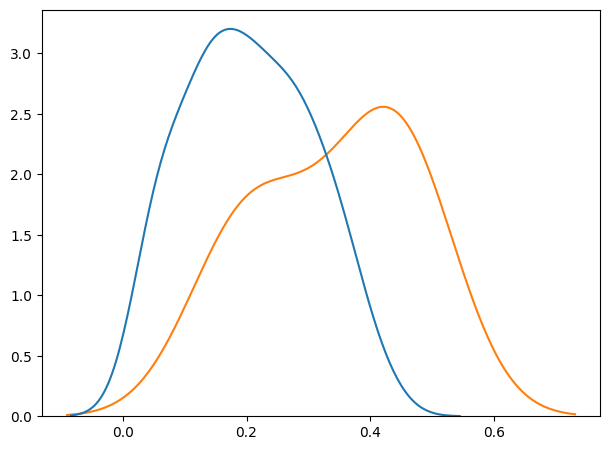

In [34]:

temp_df = conservation_df[conservation_df.expression.between(80, 120)]
plot_distributions(temp_df)
plt.legend().remove()
# remove axis labels and tick labels but keep the ticks
plt.xlabel('')
plt.ylabel('')





# Merge all plots

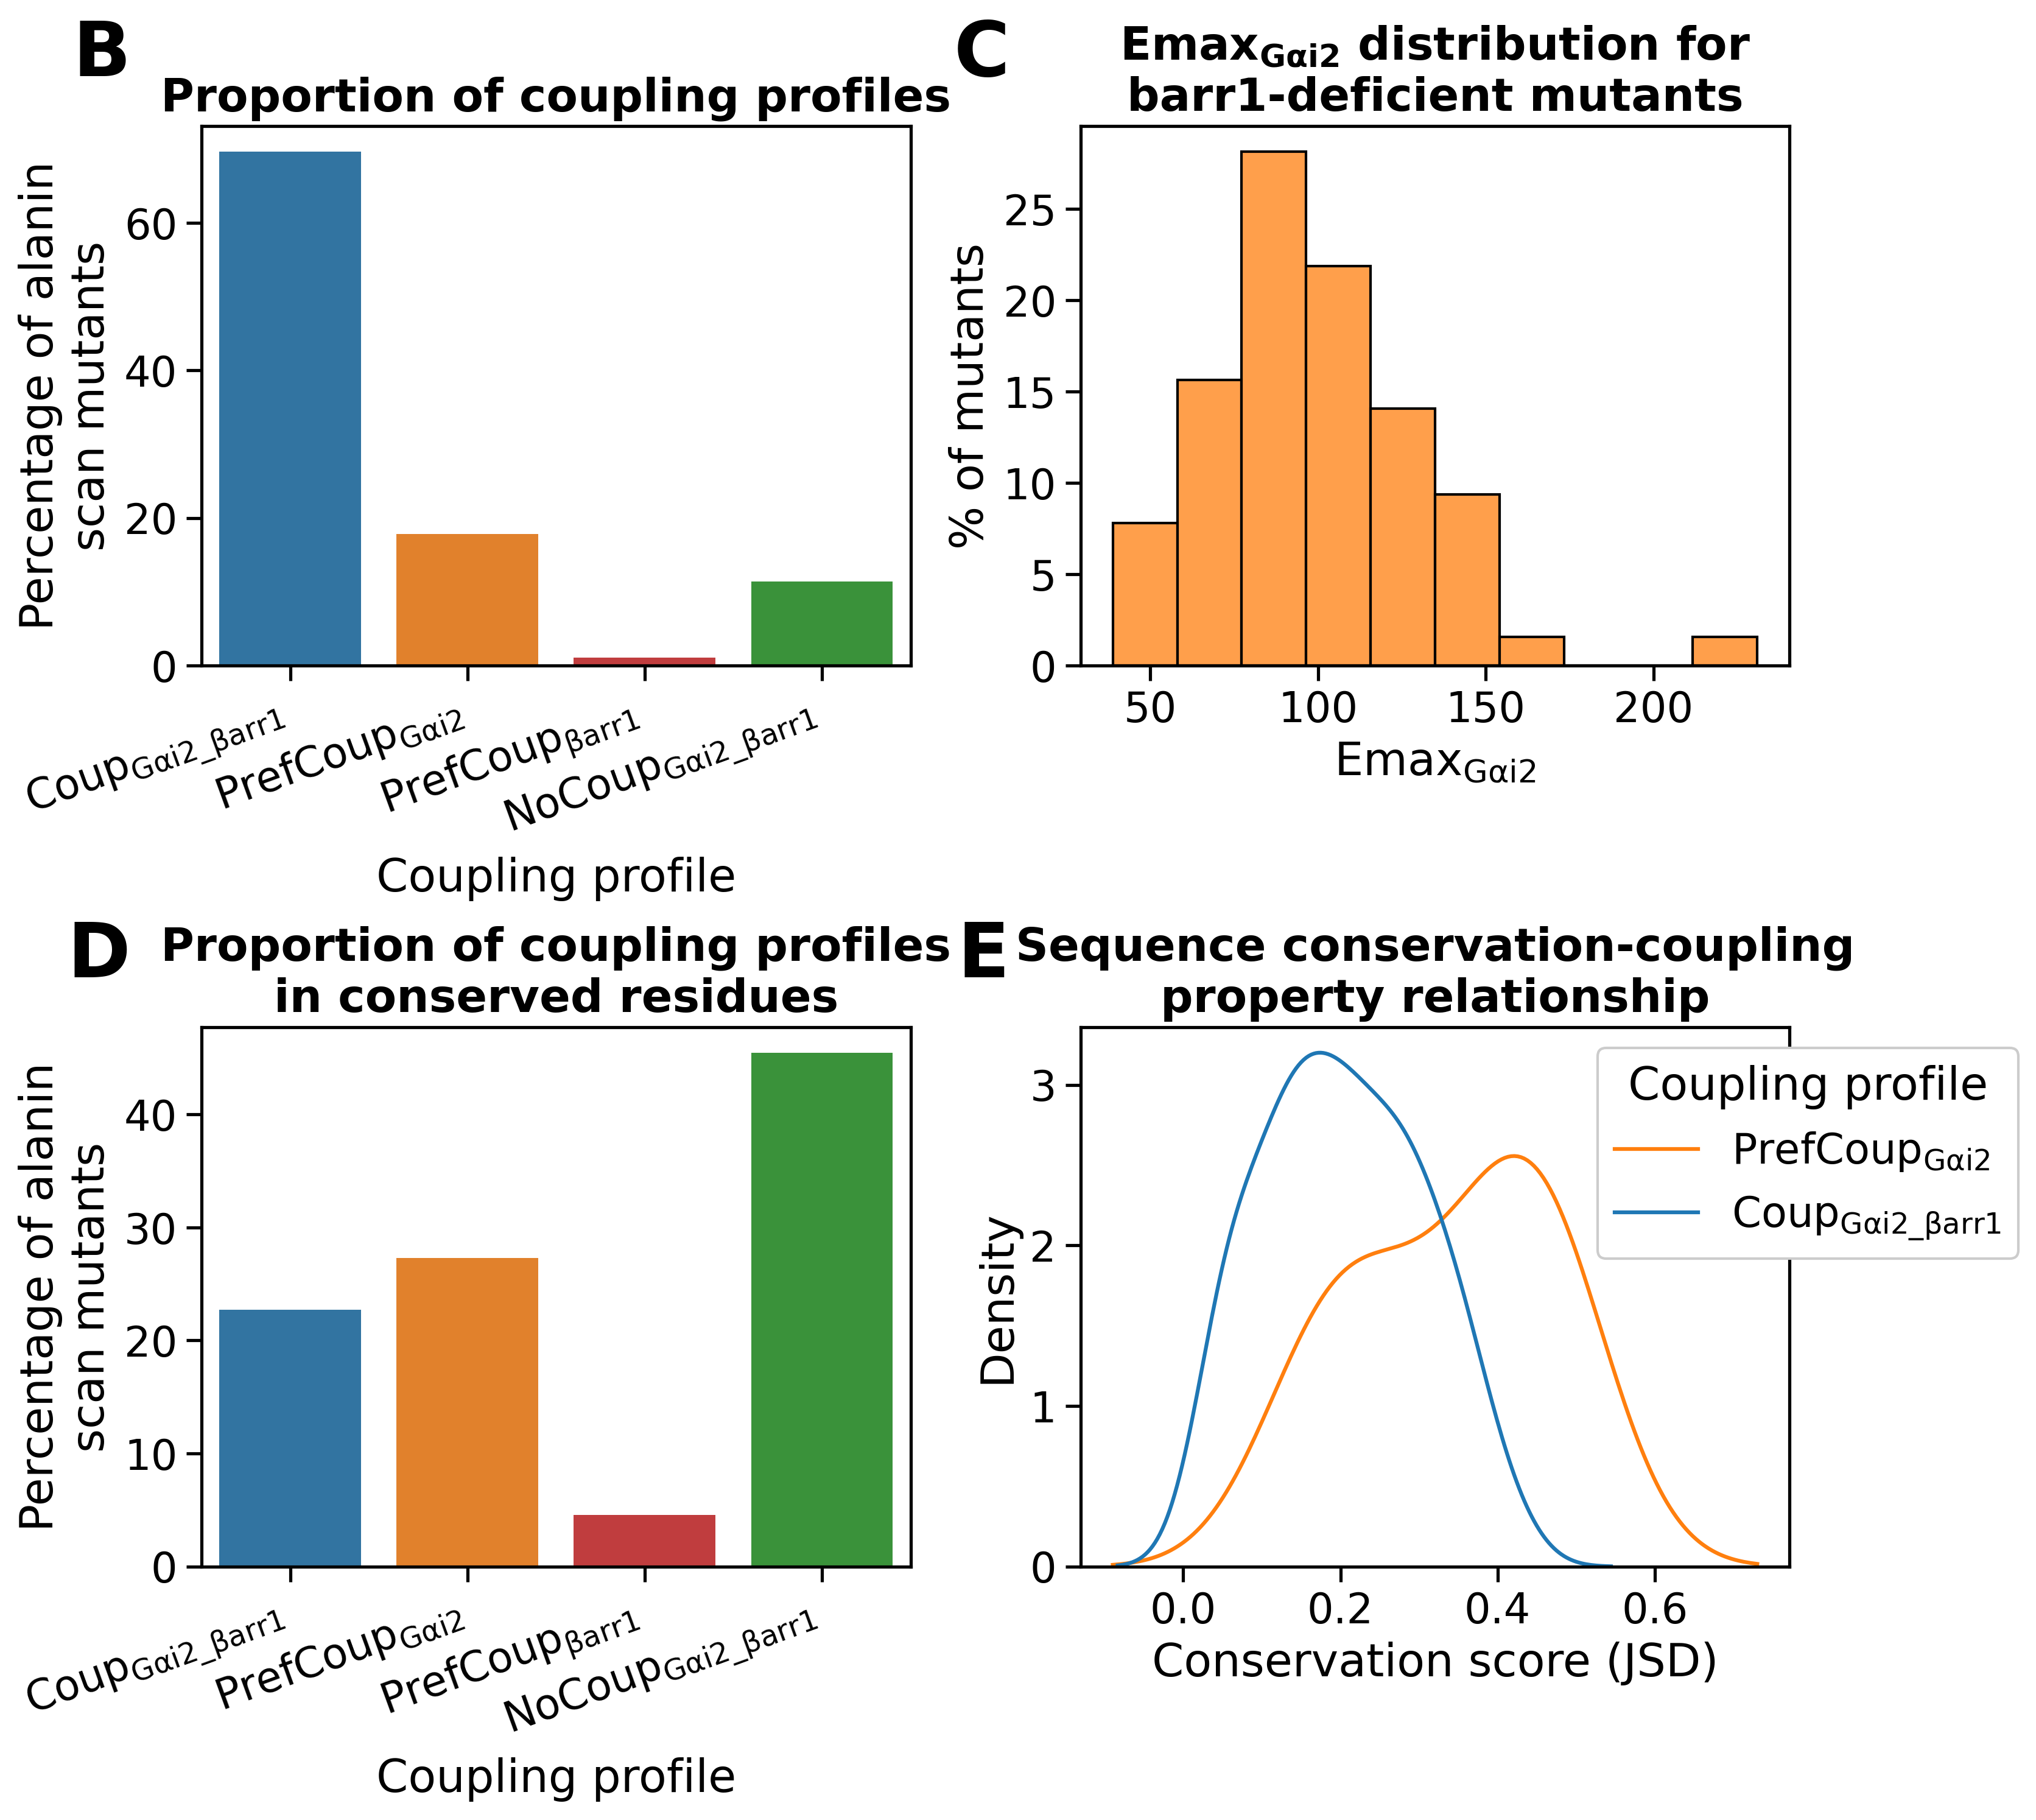

In [54]:
# make a grid with all the plots in the same figure
fig, axes = plt.subplots(2, 2, figsize=(10,10), dpi=300)

# sns.set_context("notebook", font_scale=1.5)  # This will scale the font size up by 1.5 times.
plt.rcParams.update({'font.size': 9})

plt.subplot(2, 2, 1)
temp_profile_df = profile_df.copy()
temp_profile_df.ratio = temp_profile_df.ratio * 100
g = sns.barplot(data=temp_profile_df, x='profile', y='ratio', order=['WT-like', 'barr loss', 'Gi loss', 'both loss'], palette=palette)
plt.xlabel('Coupling profile')
plt.ylabel('Percentage of alanin\nscan mutants')
plt.title('Proportion of coupling profiles', fontweight="bold")
plt.xticks(ticks=[0,1,2,3] ,labels=new_tick_lables, rotation=20, ha='right')

plt.subplot(2, 2, 2)
# create a mask for gi > 0 and barr = 0
gi_mask = df.gi > 0
barr_mask = df.barr1 == 0
temp_df = df.copy()
# multiply gi by 100
temp_df.gi = temp_df.gi * 100
sns.histplot(data=temp_df[gi_mask & barr_mask], x='gi', stat='percent', color=sns.color_palette()[1])
plt.xlabel(r'$\mathrm{Emax_{G \alpha i2}}$')
plt.ylabel('% of mutants')
plt.title(r"$\mathrm{\mathbf{Emax_{G\alpha i2}}}$" " distribution for\nbarr1-deficient mutants", fontweight="bold")

plt.subplot(2, 2, 3)
sns.barplot(data=conserved_profile, x='set', y='ratio', order=['WT-like', 'barr loss', 'Gi loss', 'both loss'], palette=palette)
plt.xlabel('Coupling profile')
plt.ylabel('Percentage of alanin\nscan mutants')
plt.title('Proportion of coupling profiles\nin conserved residues', fontweight="bold")
plt.xticks(ticks=[0,1,2,3] ,labels=new_tick_lables, rotation=20, ha='right')

plt.subplot(2, 2, 4)
temp_df = conservation_df[conservation_df.expression.between(80, 120)]
plot_distributions(temp_df)
# set legend outside the plot
plt.legend(title='Coupling profile', labels=[r'$\mathrm{PrefCoup_{G\alpha i2}}$',
                                              r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$'],
                                                bbox_to_anchor=(0.7, 1), loc='upper left', framealpha=1)
plt.title("Sequence conservation-coupling\nproperty relationship", fontweight="bold")

# add panel labels startign by B

label_coords = -0.1, 1.2
label_font_size = 30
plt.subplot(2,2,1)
plt.text(*label_coords, 'B', transform=plt.gca().transAxes, fontsize=label_font_size, fontweight='bold', va='top', ha='right')
plt.subplot(2,2,2)
plt.text(*label_coords, 'C', transform=plt.gca().transAxes, fontsize=label_font_size, fontweight='bold', va='top', ha='right')
plt.subplot(2,2,3)
plt.text(*label_coords, 'D', transform=plt.gca().transAxes, fontsize=label_font_size, fontweight='bold', va='top', ha='right')
plt.subplot(2,2,4)
plt.text(*label_coords, 'E', transform=plt.gca().transAxes, fontsize=label_font_size, fontweight='bold', va='top', ha='right')
plt.show()

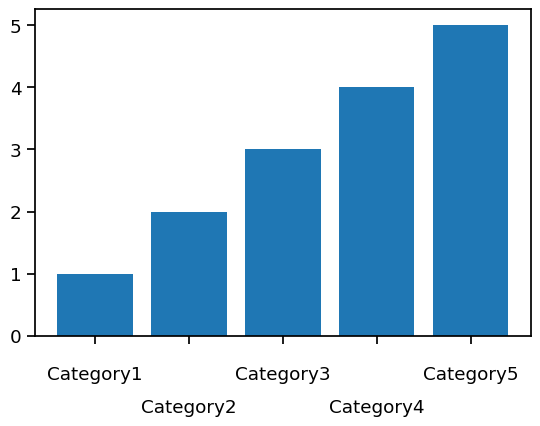

In [80]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Category1', 'Category2', 'Category3', 'Category4', 'Category5']
values = [1, 2, 3, 4, 5]

plt.bar(categories, values)

# Get current axes
ax = plt.gca()

# Iterate over the labels and use index to alternate their position
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 == 0:  # Even index
        label.set_y(-0.05)
    else:  # Odd index
        label.set_y(-0.15)

# Adjust the bottom of the plot to accommodate the new label positions
plt.subplots_adjust(bottom=0.2)

plt.show()
